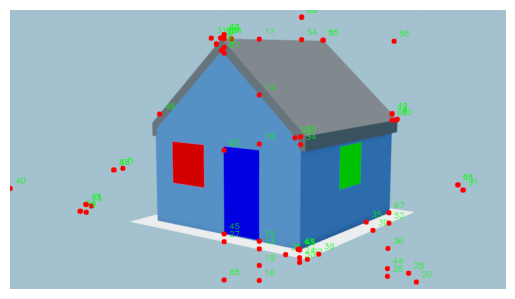

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load image for processing

img = cv2.imread('../Assets/house1.png')

# Convert to grayscale and detect edges
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# Detect lines using Probabilistic Hough Transform
lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=100,
                        minLineLength=100, maxLineGap=10)

# Function to compute intersection between two lines
def compute_intersection(line1, line2):
    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    denom = (x1 - x2)*(y3 - y4) - (y1 - y2)*(x3 - x4)
    if denom == 0:
        return None
    px = ((x1*y2 - y1*x2)*(x3 - x4) - (x1 - x2)*(x3*y4 - y3*x4)) / denom
    py = ((x1*y2 - y1*x2)*(y3 - y4) - (y1 - y2)*(x3*y4 - y3*x4)) / denom
    return int(px), int(py)

# Compute all intersections of detected lines
intersections = []
if lines is not None:
    for i in range(len(lines)):
        for j in range(i + 1, len(lines)):
            pt = compute_intersection(lines[i][0], lines[j][0])
            if pt:
                x, y = pt
                # Keep only points within image bounds
                if 0 <= x < img.shape[1] and 0 <= y < img.shape[0]:
                    intersections.append((x, y))

# Draw and label intersection points
for idx, (x, y) in enumerate(intersections, start=1):
    cv2.circle(img, (x, y), radius=5, color=(0, 0, 255), thickness=-1)
    cv2.putText(img, str(idx), (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX,
                0.5, (0, 255, 0), 1)

# Display annotated image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
